<a href="https://colab.research.google.com/github/Dimildizio/bfs_pyg/blob/master/dotsnrows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python-headless
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import random
import time
from IPython.display import display, clear_output

In [2]:
image_path = '.jpg'
IMG = cv2.imread(image_path)

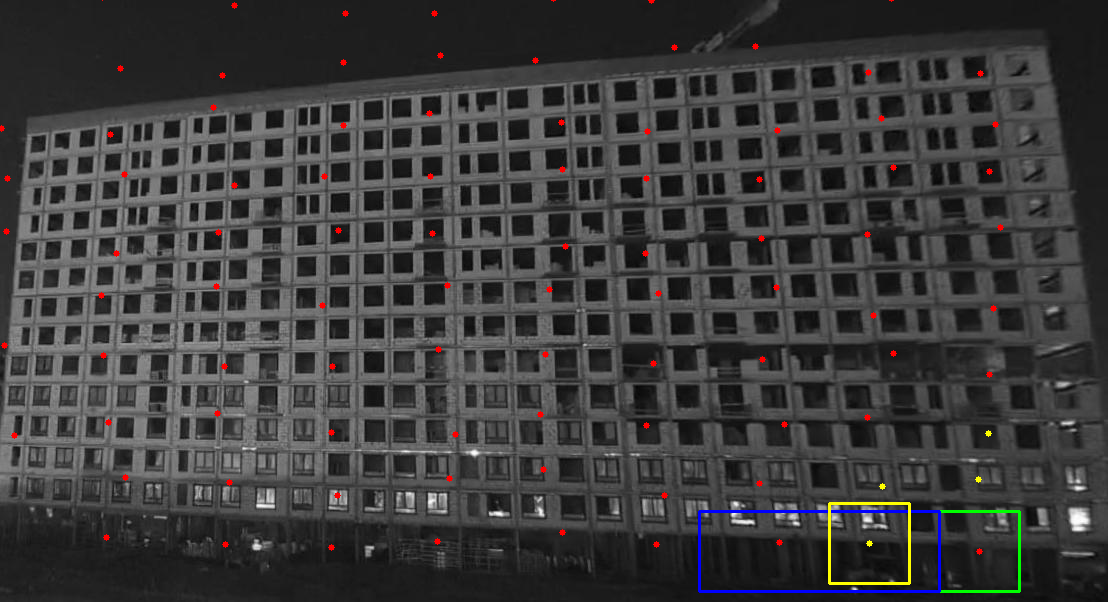

In [26]:
image = IMG.copy()
num_rows = 10
num_cols = 10
shift = 15
height, width, _ = image.shape

row_step = height // num_rows
col_step = width // num_cols
points = []
for i in range(num_rows):
    for j in range(num_cols):
        x = j * col_step + random.randint(-shift, shift)
        y = i * row_step + random.randint(-shift, shift)

        cv2.circle(image, (x, y), 3, (0, 0, 255), -1)  # -1 fills the circle
        points.append((x, y))


highest_x_y = max(points, key=lambda p: (p[0]+p[1]))
lowest_x_y = min(points, key=lambda p: (p[0]+p[1]))
rect_width = 80
rect_height = 80

first = np.array(highest_x_y) - (rect_width//2, rect_height//2)
cv2.rectangle(image, tuple(first), tuple(first+(rect_width, rect_height)),  (0, 255, 0), 2)

def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def get_n_nearest_neighbors(point, all_points, n):
    distances = [(p, euclidean_distance(point, p)) for p in all_points if p != point]
    distances.sort(key=lambda x: x[1])
    return distances[:n]

n_neighbors = 4
neighbors = get_n_nearest_neighbors(highest_x_y, points, n_neighbors)

for neighbor in neighbors:
    cv2.circle(image, neighbor[0], 3, (0, 255, 255), -1)

blue_rect_width = rect_width*3
blue_rect_height = rect_height
blue_rect_start = first - (blue_rect_width, 0)
cv2.rectangle(image, tuple(blue_rect_start), tuple(blue_rect_start+(blue_rect_width, blue_rect_height)), (255, 0, 0), 2)

def is_inside_blue_rect(point, blue_rect_start, blue_rect_width, blue_rect_height):
    x, y = point
    bx, by = blue_rect_start
    return (bx < x < bx + blue_rect_width) and (by < y < by + blue_rect_height)

neighbors_inside_blue_rect = [neighbor for neighbor in neighbors if is_inside_blue_rect(neighbor[0], blue_rect_start, blue_rect_width, blue_rect_height)]

most_aligning_neighbor = max(neighbors_inside_blue_rect, key=lambda p: abs(p[0] - first[0]))

# Draw yellow rectangle around the most aligning neighbor
rect_top_left = np.array(most_aligning_neighbor[0]) - (rect_width//2, rect_height//2)
rect_bottom_right = rect_top_left + (rect_width, rect_height)
cv2.rectangle(image, tuple(rect_top_left), tuple(rect_bottom_right), (0, 255, 255), 2)
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()